# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [114]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [115]:
websites = pd.read_csv('website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [116]:
# Your code here
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,NaN,NaN,10/10/2015 18:21,NaN,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,NaN,NaN,NaN,NaN,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,NaN,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [117]:
websites.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1774 non-null   object 
 4   SERVER                     1605 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1475 non-null   object 
 7   WHOIS_STATEPRO             1419 non-null   object 
 8   WHOIS_REGDATE              1654 non-null   object 
 9   WHOIS_UPDATED_DATE         1642 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

In [118]:
# Your comment here
#What are the data types? - object , int64, float64
#Which columns contain the features of the websites? - URL, CHARSET, SERVER, WHOIS_COUNTRY, CONTENT_LENGTH
#Which column contains the feature we will predict? What is the code standing for benign vs malicious websites? - The column to predict is Type 1 - malicious, 0 - benign
#Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns? - URL, CHARSET, SERVER, WHOIS_COUNTRY, CONTENT_LENGTH

#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [119]:
# Your code here
# Select only numerical columns for correlation calculation.
websites_corr = websites.select_dtypes(include=['int64', 'float64']).corr()
websites_corr

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048,0.280897
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852


In [120]:
!pip install seaborn==0.11.0

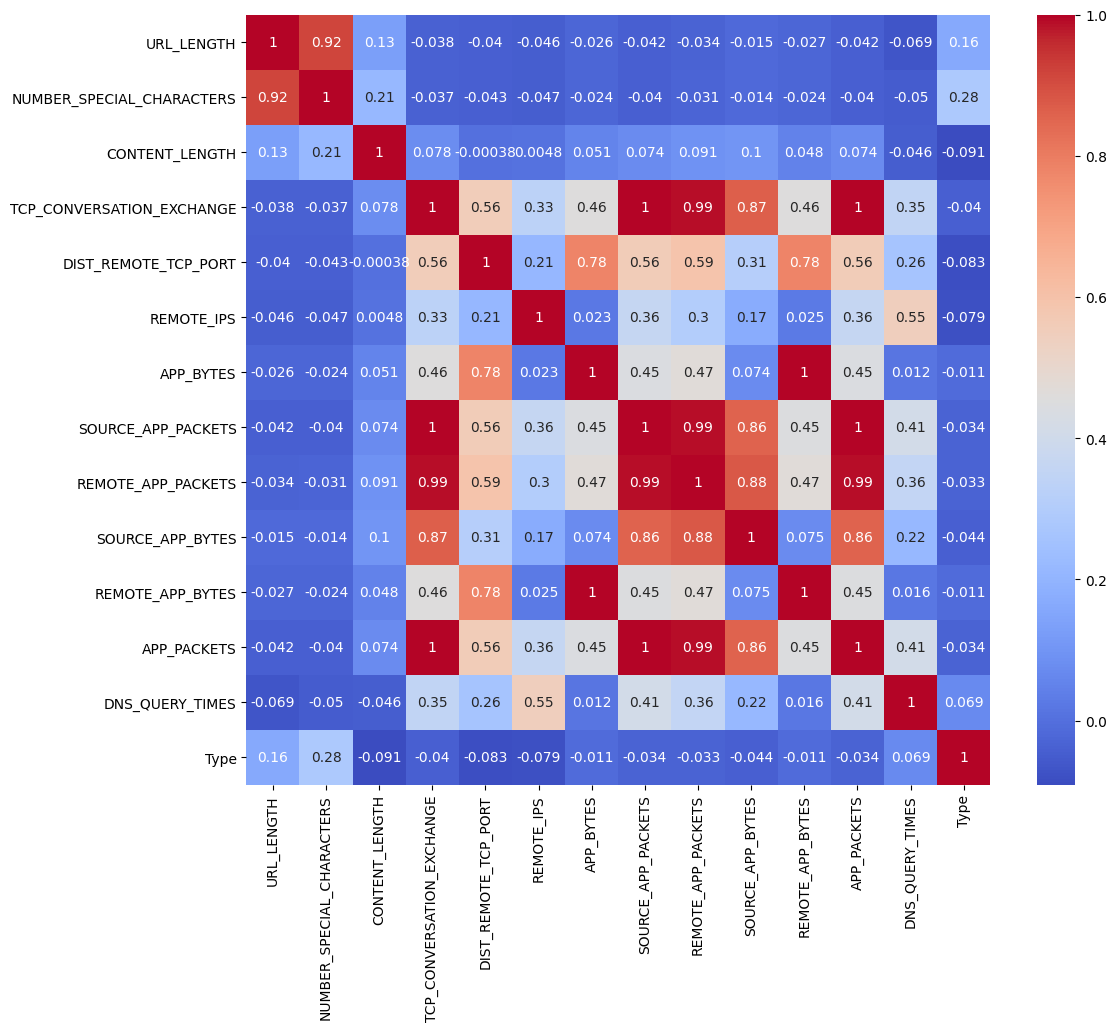

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = websites_corr

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [122]:
# Your comment here
#In the given heatmap, high collinearity can be identified where the correlation values are close to 1 or -1. Based on this, the following columns exhibit high correlations and might need removal:

#NUMBER_SPECIAL_CHARACTERS has high correlation (0.92) with URL_LENGTH.
#REMOTE_APP_PACKETS has very high correlation (0.99) with TCP_CONVERSATION_EXCHANGE.
#SOURCE_APP_PACKETS and APP_PACKETS are also highly correlated (0.99)

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [123]:
# Your code here
# Step 1: Drop 'NUMBER_SPECIAL_CHARACTERS' column
websites = websites.drop(columns=['NUMBER_SPECIAL_CHARACTERS'])

# Step 2: Recalculate the correlation matrix with only numeric columns
websites_corr = websites.select_dtypes(include=['int64', 'float64']).corr()
websites_corr


,URL_LENGTH,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
CONTENT_LENGTH,0.129745,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852
REMOTE_APP_BYTES,-0.026686,0.047595,0.458702,0.781212,0.025324,0.999992,0.447448,0.470401,0.075328,1.000000,0.447448,0.016215,-0.011004


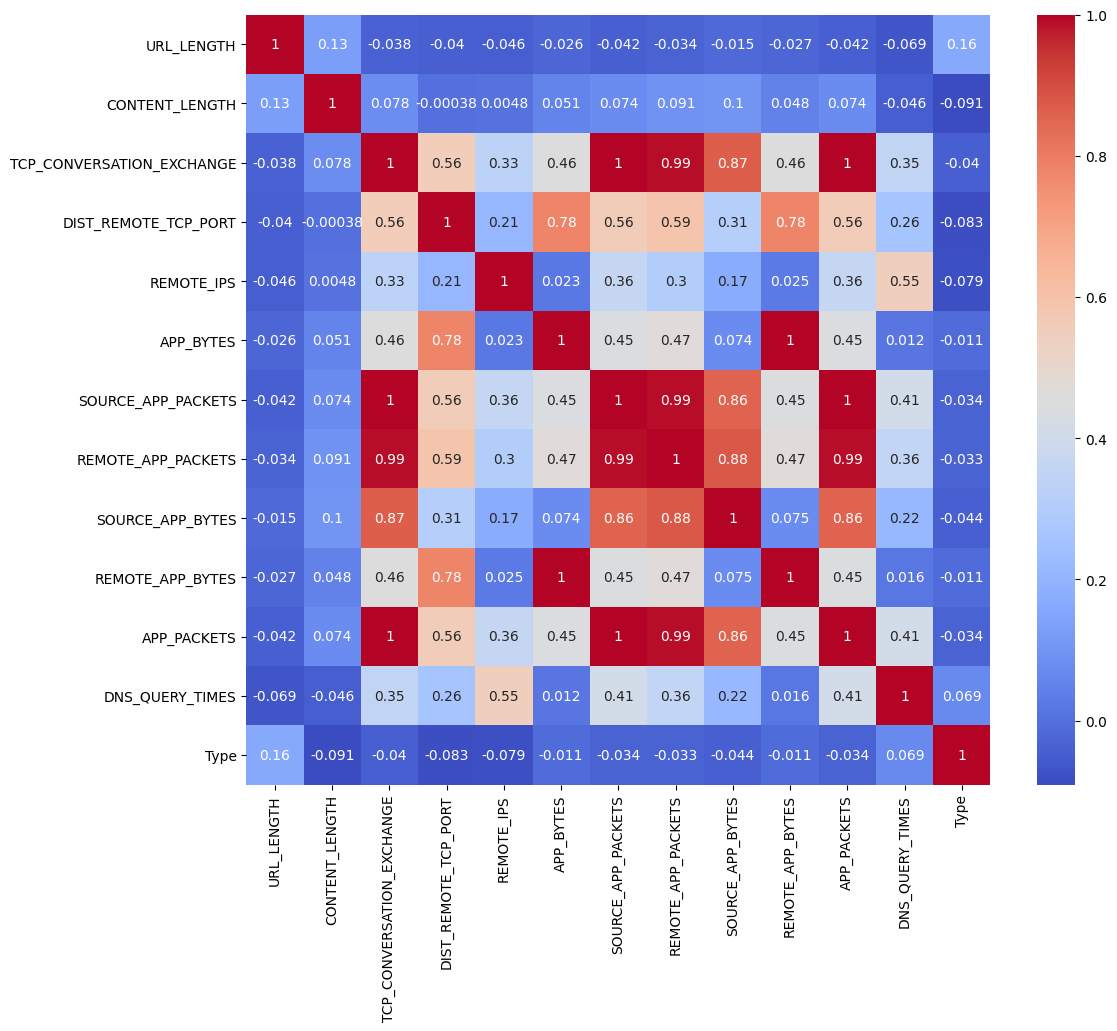

In [124]:
# Print heatmap again
# Step 3: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(websites_corr, annot=True, cmap='coolwarm')
plt.show()

In [125]:
# Your comment here
#Based on the new correlation matrix provided:

#REMOTE_APP_PACKETS and TCP_CONVERSATION_EXCHANGE have a correlation of 0.99.
#SOURCE_APP_PACKETS and APP_PACKETS have a correlation of 0.99.

In [126]:
websites = websites.drop(columns=['REMOTE_APP_PACKETS'])

# Step 2: Recalculate the correlation matrix with only numeric columns
websites_corr = websites.select_dtypes(include=['int64', 'float64']).corr()
websites_corr

,URL_LENGTH,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
CONTENT_LENGTH,0.129745,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.857495,0.447448,1.000000,0.410843,-0.034414
SOURCE_APP_BYTES,-0.014857,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,1.000000,0.075328,0.857495,0.215285,-0.043852
REMOTE_APP_BYTES,-0.026686,0.047595,0.458702,0.781212,0.025324,0.999992,0.447448,0.075328,1.000000,0.447448,0.016215,-0.011004
APP_PACKETS,-0.042264,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.857495,0.447448,1.000000,0.410843,-0.034414


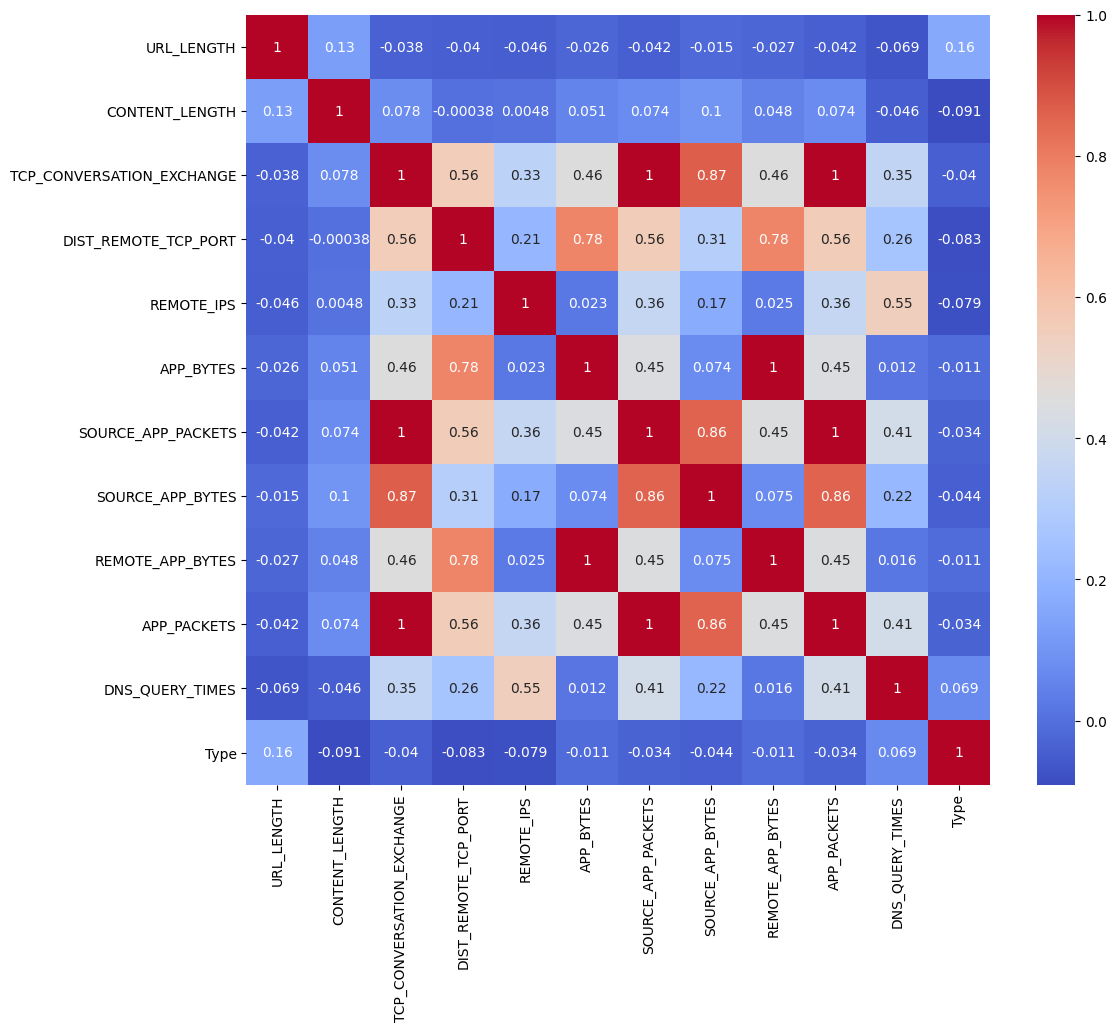

In [127]:
# Step 3: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(websites_corr, annot=True, cmap='coolwarm')
plt.show()

In [128]:
websites = websites.drop(columns=['APP_PACKETS'])

# Step 2: Recalculate the correlation matrix with only numeric columns
websites_corr = websites.select_dtypes(include=['int64', 'float64']).corr()
websites_corr

,URL_LENGTH,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.014857,-0.026686,-0.068582,0.162104
CONTENT_LENGTH,0.129745,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.100094,0.047595,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.865580,0.458702,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.313359,0.781212,0.259942,-0.082925
REMOTE_IPS,-0.046367,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.171651,0.025324,0.548189,-0.078783
APP_BYTES,-0.026446,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.074464,0.999992,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.857495,0.447448,0.410843,-0.034414
SOURCE_APP_BYTES,-0.014857,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,1.000000,0.075328,0.215285,-0.043852
REMOTE_APP_BYTES,-0.026686,0.047595,0.458702,0.781212,0.025324,0.999992,0.447448,0.075328,1.000000,0.016215,-0.011004
DNS_QUERY_TIMES,-0.068582,-0.045644,0.349832,0.259942,0.548189,0.012221,0.410843,0.215285,0.016215,1.000000,0.068753


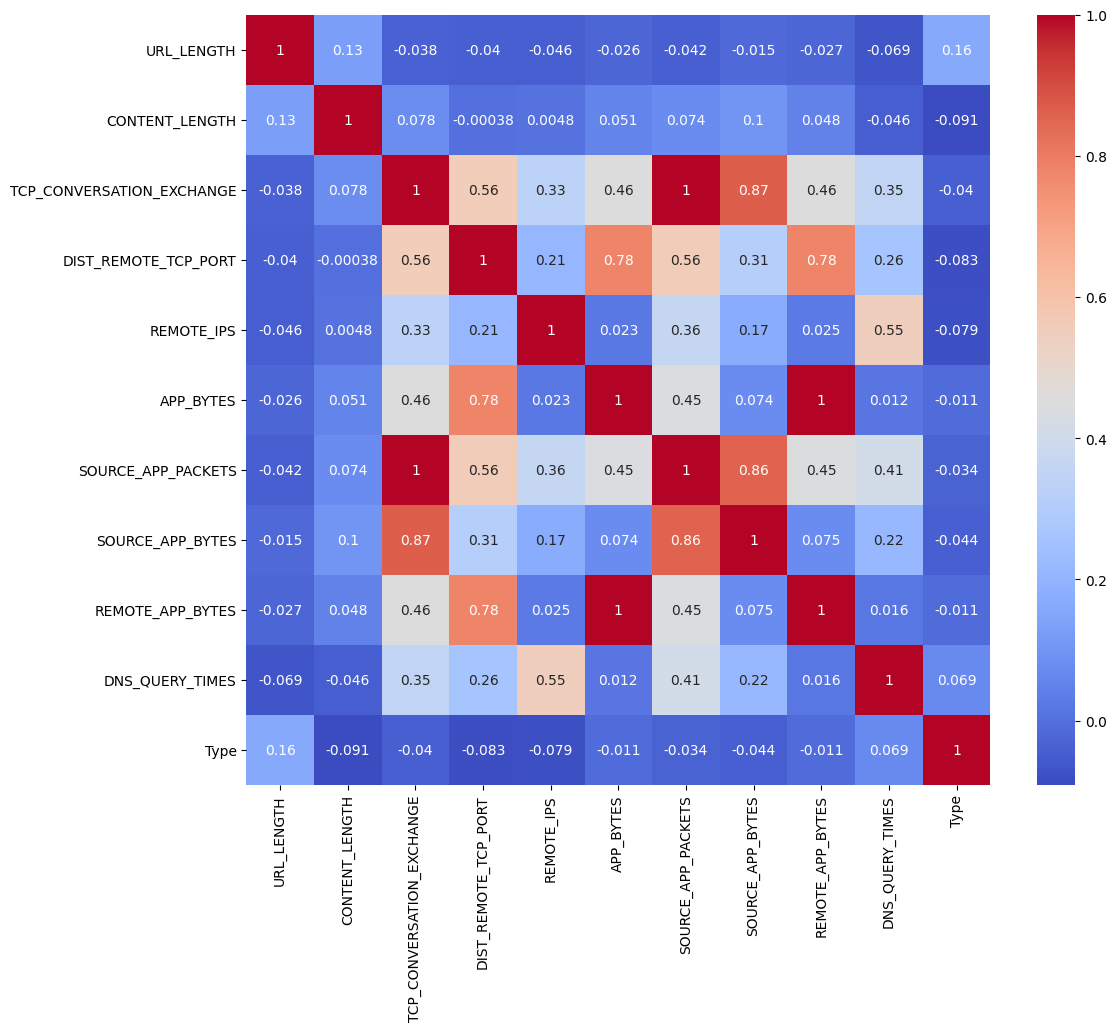

In [129]:
# Step 3: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(websites_corr, annot=True, cmap='coolwarm')
plt.show()

In [130]:
#Comments: Summary of Removed Columns:
#NUMBER_SPECIAL_CHARACTERS: Removed due to high correlation with URL_LENGTH.
#REMOTE_APP_PACKETS: Removed due to high correlation with TCP_CONVERSATION_EXCHANGE.
#APP_PACKETS: Removed due to high correlation with SOURCE_APP_PACKETS.

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [131]:
# Your code here
websites.isnull().sum()

,0
URL,0
URL_LENGTH,0
CHARSET,7
SERVER,176
CONTENT_LENGTH,812
WHOIS_COUNTRY,306
WHOIS_STATEPRO,362
WHOIS_REGDATE,127
WHOIS_UPDATED_DATE,139
TCP_CONVERSATION_EXCHANGE,0


If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [132]:
# Fill missing values for categorical columns with the mode
websites['CHARSET'] = websites['CHARSET'].fillna(websites['CHARSET'].mode()[0])
websites['SERVER'] = websites['SERVER'].fillna(websites['SERVER'].mode()[0])
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].fillna(websites['WHOIS_COUNTRY'].mode()[0])
websites['WHOIS_STATEPRO'] = websites['WHOIS_STATEPRO'].fillna(websites['WHOIS_STATEPRO'].mode()[0])
websites['WHOIS_REGDATE'] = websites['WHOIS_REGDATE'].fillna(websites['WHOIS_REGDATE'].mode()[0])
websites['WHOIS_UPDATED_DATE'] = websites['WHOIS_UPDATED_DATE'].fillna(websites['WHOIS_UPDATED_DATE'].mode()[0])

# Fill missing values for 'CONTENT_LENGTH' with the median
websites['CONTENT_LENGTH'] = websites['CONTENT_LENGTH'].fillna(websites['CONTENT_LENGTH'].median())

# Fill missing value for 'DNS_QUERY_TIMES' with the mean
websites['DNS_QUERY_TIMES'] = websites['DNS_QUERY_TIMES'].fillna(websites['DNS_QUERY_TIMES'].mean())


In [133]:
# Your comment here
'''CHARSET, SERVER, WHOIS_COUNTRY, WHOIS_STATEPRO, WHOIS_REGDATE, and WHOIS_UPDATED_DATE have missing values. Since these columns contain categorical data, we can:

Fill with Mode: Replace missing values with the mode (most frequent value) since these columns are likely to have a few dominant values, and filling with the mode ensures minimal distortion.
CONTENT_LENGTH has 812 missing values, and since it is numeric, we can:

Fill with Median: Use the median value, as it is less affected by outliers and will provide a more robust estimate for missing numeric values.
DNS_QUERY_TIMES has 1 missing value, and since it is numeric, we can:

Fill with Mean: Since it only has a single missing value, using the mean should suffice without introducing much bias.'''

'CHARSET, SERVER, WHOIS_COUNTRY, WHOIS_STATEPRO, WHOIS_REGDATE, and WHOIS_UPDATED_DATE have missing values. Since these columns contain categorical data, we can:\n\nFill with Mode: Replace missing values with the mode (most frequent value) since these columns are likely to have a few dominant values, and filling with the mode ensures minimal distortion.\nCONTENT_LENGTH has 812 missing values, and since it is numeric, we can:\n\nFill with Median: Use the median value, as it is less affected by outliers and will provide a more robust estimate for missing numeric values.\nDNS_QUERY_TIMES has 1 missing value, and since it is numeric, we can:\n\nFill with Mean: Since it only has a single missing value, using the mean should suffice without introducing much bias.'

#### Again, examine the number of missing values in each column.

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [134]:
# Examine missing values in each column
websites.isnull().sum()


,0
URL,0
URL_LENGTH,0
CHARSET,0
SERVER,0
CONTENT_LENGTH,0
WHOIS_COUNTRY,0
WHOIS_STATEPRO,0
WHOIS_REGDATE,0
WHOIS_UPDATED_DATE,0
TCP_CONVERSATION_EXCHANGE,0


# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [135]:
# Your code here
# List unique values of WHOIS_COUNTRY
unique_countries = websites['WHOIS_COUNTRY'].unique()
print(unique_countries)

['US' 'SC' 'GB' 'UK' 'RU' 'AU' 'CA' 'PA' 'se' 'IN' 'LU' 'TH'
 "[u'GB'; u'UK']" 'FR' 'NL' 'UG' 'JP' 'CN' 'SE' 'SI' 'IL' 'ru' 'KY' 'AT'
 'CZ' 'PH' 'BE' 'NO' 'TR' 'LV' 'DE' 'ES' 'BR' 'us' 'KR' 'HK' 'UA' 'CH'
 'United Kingdom' 'BS' 'PK' 'IT' 'Cyprus' 'BY' 'AE' 'IE' 'UY' 'KG']


In [136]:
# Consolidate WHOIS_COUNTRY values with consistent codes
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace({
    'Cyprus': 'CY',
    'us': 'US',
    'se': 'SE',
    'United Kingdom': 'GB',
    "[u'GB'; u'UK']": 'GB'
})


In [137]:
# Verify the updated unique values
unique_countries_updated = websites['WHOIS_COUNTRY'].unique()
print(unique_countries_updated)


['US' 'SC' 'GB' 'UK' 'RU' 'AU' 'CA' 'PA' 'SE' 'IN' 'LU' 'TH' 'FR' 'NL'
 'UG' 'JP' 'CN' 'SI' 'IL' 'ru' 'KY' 'AT' 'CZ' 'PH' 'BE' 'NO' 'TR' 'LV'
 'DE' 'ES' 'BR' 'KR' 'HK' 'UA' 'CH' 'BS' 'PK' 'IT' 'CY' 'BY' 'AE' 'IE'
 'UY' 'KG']


Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

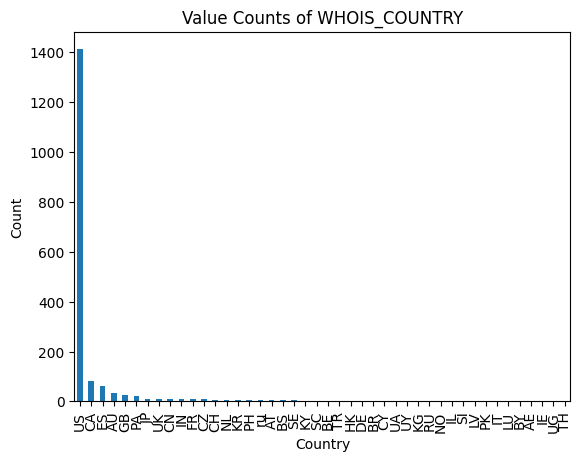

In [138]:
# Your code here
country_counts = websites['WHOIS_COUNTRY'].value_counts()
country_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Value Counts of WHOIS_COUNTRY')
plt.show()

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [139]:
# Your code here
# Get the top 10 values from WHOIS_COUNTRY
top_10_countries = websites['WHOIS_COUNTRY'].value_counts().nlargest(10).index

# Replace all other values with 'OTHER'
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x: x if x in top_10_countries else 'OTHER')

# Verify the changes
print(websites['WHOIS_COUNTRY'].value_counts())


WHOIS_COUNTRY
US       1412
OTHER     100
CA         84
ES         63
AU         35
GB         25
PA         21
JP         11
UK         10
IN         10
CN         10
Name: count, dtype: int64


Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [140]:
# Your code here
websites = websites.drop(columns=['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'])
websites.head()

,URL,URL_LENGTH,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,16,iso-8859-1,nginx,263.0,US,7,0,2,700,9,1153,832,2.0,1
1,B0_2314,16,UTF-8,Apache/2.4.10,15087.0,US,17,7,4,1230,17,1265,1230,0.0,0
2,B0_911,16,us-ascii,Microsoft-HTTPAPI/2.0,324.0,US,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,ISO-8859-1,nginx,162.0,US,31,22,3,3812,39,18784,4380,8.0,0
4,B0_403,17,UTF-8,Apache,124140.0,US,57,2,5,4278,61,129889,4586,4.0,0


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [160]:
# Your code here
websites.dtypes


,0
URL,object
URL_LENGTH,int64
CHARSET,object
SERVER,object
CONTENT_LENGTH,float64
WHOIS_COUNTRY,object
TCP_CONVERSATION_EXCHANGE,int64
DIST_REMOTE_TCP_PORT,int64
REMOTE_IPS,int64
APP_BYTES,int64


#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [161]:
# Your code here
websites = websites.drop(columns=['URL'])
websites.head()


,URL_LENGTH,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
0,16,iso-8859-1,nginx,263.0,US,7,0,2,700,9,1153,832,2.0,1
1,16,UTF-8,Apache/2.4.10,15087.0,US,17,7,4,1230,17,1265,1230,0.0,0
2,16,us-ascii,Microsoft-HTTPAPI/2.0,324.0,US,0,0,0,0,0,0,0,0.0,0
3,17,ISO-8859-1,nginx,162.0,US,31,22,3,3812,39,18784,4380,8.0,0
4,17,UTF-8,Apache,124140.0,US,57,2,5,4278,61,129889,4586,4.0,0


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [162]:
# Your code here
websites['CHARSET'].value_counts()

,count
CHARSET,
UTF-8,683
ISO-8859-1,427
utf-8,379
us-ascii,155
iso-8859-1,134
windows-1251,1
ISO-8859,1
windows-1252,1


`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [163]:
# Your code here
websites['SERVER'].value_counts()

,count
SERVER,
Apache,562
nginx,211
Microsoft-HTTPAPI/2.0,113
cloudflare-nginx,94
Microsoft-IIS/7.5,51
...,...
mw2103.codfw.wmnet,1
Apache/2.4.25 (Debian),1
ECD (fll/0790),1


![Think Hard](../images/think-hard.jpg)

In [145]:
# Your comment here
'''The SERVER column has many unique values, with a few dominant ones and many rare ones, which makes it challenging to work with directly. To simplify the data:

Step 1: Consolidate Server Types
Group by Server Families: Consolidate server values by grouping similar ones together.'''


Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [166]:
# Your code here
# Define function to consolidate server types
def consolidate_server(value):
    if 'Apache' in value:
        return 'Apache'
    elif 'nginx' in value:
        return 'nginx'
    elif 'Microsoft' in value:
        return 'Microsoft'
    else:
        return 'Other'

# Apply function to consolidate the SERVER column
websites['SERVER'] = websites['SERVER'].apply(consolidate_server)

In [165]:
# Count `SERVER` value counts here
# Verify the unique values after consolidation
print(websites['SERVER'].value_counts())

SERVER
Apache       819
nginx        435
Other        329
Microsoft    198
Name: count, dtype: int64


OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [168]:
# Your code here
website_dummy = pd.get_dummies(websites)
website_dummy.head()

,URL_LENGTH,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,...,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_GB,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_OTHER,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,16,263.0,7,0,2,700,9,1153,832,2.0,...,False,False,False,False,False,False,False,False,False,True
1,16,15087.0,17,7,4,1230,17,1265,1230,0.0,...,False,False,False,False,False,False,False,False,False,True
2,16,324.0,0,0,0,0,0,0,0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,17,162.0,31,22,3,3812,39,18784,4380,8.0,...,False,False,False,False,False,False,False,False,False,True
4,17,124140.0,57,2,5,4278,61,129889,4586,4.0,...,False,False,False,False,False,False,False,False,False,True


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [169]:
# Your code here
website_dummy.dtypes


,0
URL_LENGTH,int64
CONTENT_LENGTH,float64
TCP_CONVERSATION_EXCHANGE,int64
DIST_REMOTE_TCP_PORT,int64
REMOTE_IPS,int64
APP_BYTES,int64
SOURCE_APP_PACKETS,int64
SOURCE_APP_BYTES,int64
REMOTE_APP_BYTES,int64
DNS_QUERY_TIMES,float64


# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [182]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the data into features and target variable
X = website_dummy.drop(columns=['Type'])
y = website_dummy['Type']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [183]:
# Your code here:
from sklearn.linear_model import LogisticRegression

# Fit Logistic Regression with scaled data
model = LogisticRegression(max_iter=1000)

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [184]:
# Your code here:
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [186]:
# Your code here:
from sklearn.metrics import confusion_matrix, accuracy_score

# Predict the testing set
y_pred = log_reg.predict(X_test_scaled)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the confusion matrix and accuracy score
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy Score:", accuracy)

Confusion Matrix:
[[453   9]
 [ 42  31]]

Accuracy Score: 0.9046728971962616


What are your thoughts on the performance of the model? Write your conclusions below.

In [154]:
# Your conclusions here:
'''90% seems good to me.
False negatives might be problematic, especially if the missed predictions carry
a high cost in the problem context (e.g., detecting malicious websites).
The False Positives (FP) count of 9 is relatively low compared to True Positives and True Negatives.
trying other models migh benefit in increased accuracy.

#### Our second algorithm is is K-Nearest Neighbors.

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [191]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Initialize KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model using the training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [192]:
# Your code here:
# Predict the testing set
y_pred_knn = knn.predict(X_test_scaled)

# Calculate the confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Calculate the accuracy score
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Print the confusion matrix and accuracy score
print("Confusion Matrix (KNN, k=3):")
print(conf_matrix_knn)
print("\nAccuracy Score (KNN, k=3):", accuracy_knn)

Confusion Matrix (KNN, k=3):
[[450  12]
 [ 24  49]]

Accuracy Score (KNN, k=3): 0.9327102803738317


#### We'll create another K-Nearest Neighbors model with k=5.

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [193]:
# Your code here:
# Initialize KNN classifier with k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)

# Fit the model using the training data
knn_5.fit(X_train_scaled, y_train)

# Predict the testing set
y_pred_knn_5 = knn_5.predict(X_test_scaled)

# Calculate the confusion matrix
conf_matrix_knn_5 = confusion_matrix(y_test, y_pred_knn_5)

# Calculate the accuracy score
accuracy_knn_5 = accuracy_score(y_test, y_pred_knn_5)

# Print the confusion matrix and accuracy score
print("Confusion Matrix (KNN, k=5):")
print(conf_matrix_knn_5)
print("\nAccuracy Score (KNN, k=5):", accuracy_knn_5)

Confusion Matrix (KNN, k=5):
[[449  13]
 [ 25  48]]

Accuracy Score (KNN, k=5): 0.9289719626168225


Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [158]:
# Your conclusions here:
'''Confusion Matrix: Increasing k from 3 to 5 slightly increased false negatives (from 24 to 25) and false positives (from 12 to 13), reducing correct predictions overall.
Accuracy Score: Decreased slightly from 93.27% (k=3) to 92.90% (k=5).
No improvement in performance when increasing k from 3 to 5.
The model was slightly more accurate with k=3.
k=3 provided better results with more correctly classified samples.


# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [159]:
# Your code here